In [3]:
import torch.nn as nn
import torch

from transformers import DistilBertConfig, DistilBertModel

class BasicTransformerClassifierWithAttention(nn.Module):
    def __init__(self):
        super(BasicTransformerClassifierWithAttention, self).__init__()
        config = DistilBertConfig.from_pretrained('distilbert-base-uncased', output_attentions=True)
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, html_input_ids, html_attention_mask):
        outputs = self.bert(input_ids=html_input_ids, attention_mask=html_attention_mask)
        logits = self.classifier(outputs.last_hidden_state[:, 0, :])
        return logits, outputs.attentions


model = BasicTransformerClassifierWithAttention()

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

print(device)

checkpoint_path = "../models/basic_html_transformer_phishing_classifier.pt"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))  # Adjust `map_location` as needed
model.to(device)
model.eval()



mps


BasicTransformerClassifierWithAttention(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
   

/opt/homebrew/Caskroom/miniforge/base/envs/phishing-edge/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


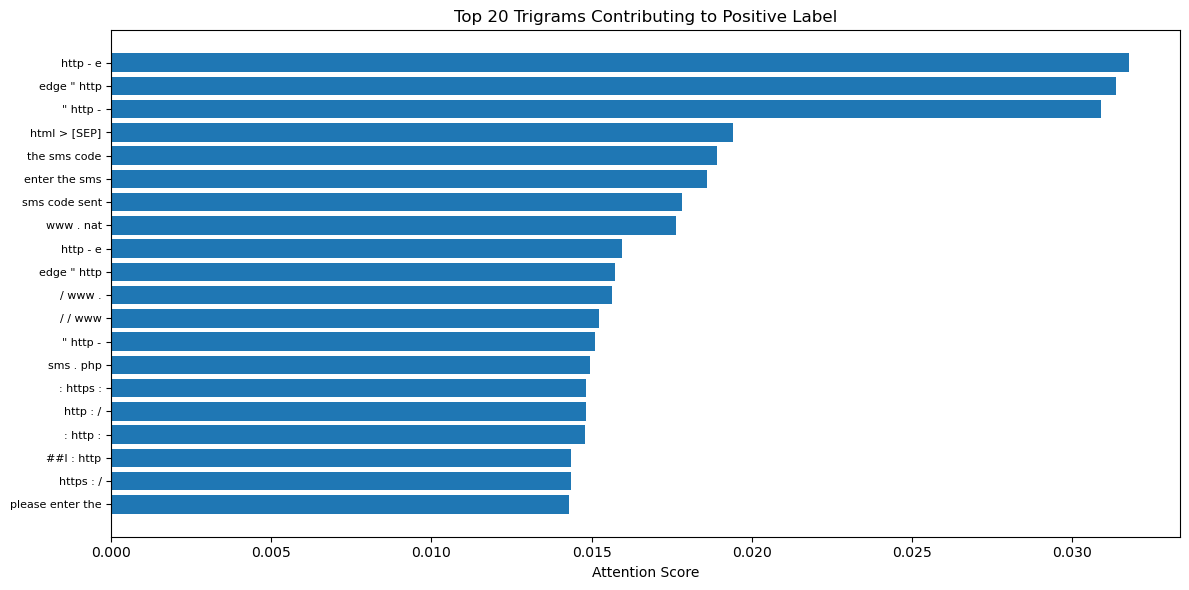

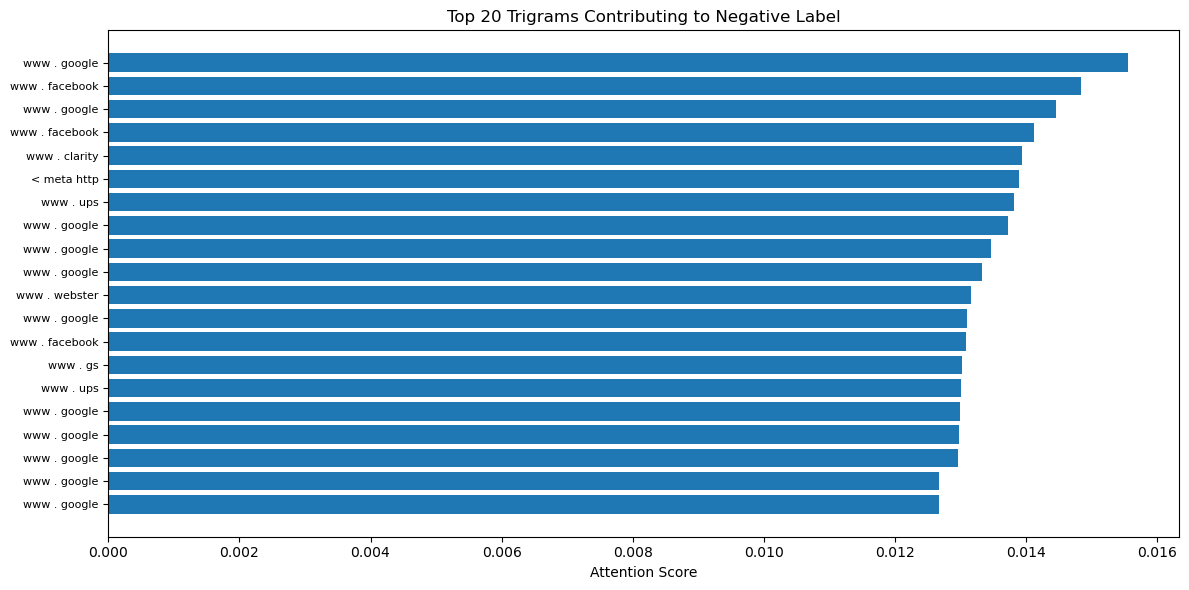

In [15]:
from torch.utils.data import DataLoader
from dataset.phishing_dataset import PhishingDataset
import os
import matplotlib.pyplot as plt
import numpy as np
from transformers import DistilBertTokenizer
dataset_path = os.path.expanduser("~/transfer/phishing_output.h5")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

test_dataset = PhishingDataset(['html_input_ids', 'labels'], split='test', local_file_path=dataset_path)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)


def get_trigram_attention(tokens, attention_scores, predictions, label_name, target_label):
        indices = np.where(predictions == target_label)[0]
        trigram_scores = []
        trigram_texts = []

        for idx in indices:
            token_scores = attention_scores[idx, 1:, 1:].mean(axis=0).detach().cpu().numpy()
            filtered_tokens = tokens[idx][1:]  # Skip the CLS token

            # Aggregate attention scores for trigrams
            trigrams = [" ".join(filtered_tokens[i:i+3]) for i in range(len(filtered_tokens) - 2)]
            trigram_scores.extend([np.sum(token_scores[i:i+3]) for i in range(len(filtered_tokens) - 2)])
            trigram_texts.extend(trigrams)

        top_indices = np.argsort(trigram_scores)[-20:]
        top_trigrams = [trigram_texts[i] for i in top_indices]
        top_scores = [trigram_scores[i] for i in top_indices]

        plt.figure(figsize=(12, 6))
        plt.barh(range(len(top_scores)), top_scores, align="center")
        plt.yticks(range(len(top_scores)), top_trigrams, fontsize=8)
        plt.xlabel("Attention Score")
        plt.title(f"Top 20 Trigrams Contributing to {label_name} Label")
        plt.tight_layout()
        plt.show()

for batch in test_dataloader:
    html_input_ids = batch['html_input_ids'].to(device)
    html_attention_mask = batch['html_attention_mask'].to(device)

    logits, attentions = model(html_input_ids, html_attention_mask)
    predictions = torch.argmax(logits, dim=1).detach().cpu().numpy()  

    tokens = [tokenizer.convert_ids_to_tokens(ids.tolist()) for ids in html_input_ids]

    layer_idx = 0
    head_agg = attentions[layer_idx].mean(dim=1)  

    # Analyze trigrams for positive and negative predictions
    get_trigram_attention(tokens, head_agg, predictions, "Positive", target_label=1)
    get_trigram_attention(tokens, head_agg, predictions, "Negative", target_label=0)
    break

In [1]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
text = "barriers and solutions for self-attention as a building block"
tokens = tokenizer.tokenize(text)
print(tokens)
print(len(tokens))

['barriers', 'and', 'solutions', 'for', 'self', '-', 'attention', 'as', 'a', 'building', 'block']
11


/opt/homebrew/Caskroom/miniforge/base/envs/phishing-edge/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [19]:
import h5py
import os
import torch
from random import randint
dataset_path = os.path.expanduser("~/transfer/phishing_output.h5")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

h5file = h5py.File(dataset_path, 'r')

def tokenize_with_overlap(html_content, max_chunk_length=512, stride=256):
    """
    Tokenize an HTML document into overlapping chunks.
    """
    # Tokenize the entire document first
    tokens = tokenizer(html_content, add_special_tokens=False)["input_ids"]
    
    # Create overlapping chunks
    chunks = []
    for i in range(0, len(tokens), stride):
        chunk = tokens[i:i + max_chunk_length]
        if len(chunk) < max_chunk_length:  # Pad shorter chunks
            chunk += [tokenizer.pad_token_id] * (max_chunk_length - len(chunk))
        chunks.append(chunk)
    
    # Convert to tensor format for the model
    input_ids = torch.tensor(chunks)
    attention_mask = (input_ids != tokenizer.pad_token_id).long()  # Mask non-padding tokens
    return input_ids, attention_mask

dev_size = len(h5file['dev/html_content'])
idx = randint(0, dev_size)
print(f"{idx}/{dev_size}")
html_content = str(h5file['dev/html_content'][idx])

# Tokenize with overlapping windows
input_ids, attention_mask = tokenize_with_overlap(html_content)

print("Input IDs Shape:", input_ids.shape)  # (num_chunks, max_chunk_length)
print("Attention Mask Shape:", attention_mask.shape)  # (num_chunks, max_chunk_length)


Token indices sequence length is longer than the specified maximum sequence length for this model (18690 > 512). Running this sequence through the model will result in indexing errors


2726/7126
Input IDs Shape: torch.Size([74, 512])
Attention Mask Shape: torch.Size([74, 512])
